# Домашнее задание по теме «Рекомендации на основе содержания»
1. Использовать dataset MovieLens
2. Построить рекомендации (регрессия, предсказываем оценку) на фичах:
- TF-IDF на тегах и жанрах
- Средние оценки (+ median, variance, etc.) пользователя и фильма
3. Оценить RMSE на тестовой выборке

## Решение

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
movies_with_tags = movies.join(tags.set_index('movieId'), on='movieId')

In [7]:
movies_with_tags.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


In [8]:
movies_with_tags_ratings = movies_with_tags.merge(ratings, on=['userId', 'movieId'], how='left', suffixes=('_tags', '_rating'))

In [9]:
movies_with_tags_ratings = movies_with_tags_ratings.drop(columns=['timestamp_tags','timestamp_rating'])
movies_with_tags_ratings.head()

,movieId,title,genres,userId,tag,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,3.5
3,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,4.0
4,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,4.0


In [10]:
movies_with_tags_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11853 entries, 0 to 11852
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  11853 non-null  int64  
 1   title    11853 non-null  object 
 2   genres   11853 non-null  object 
 3   userId   3683 non-null   float64
 4   tag      3683 non-null   object 
 5   rating   3476 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 648.2+ KB


##### Фича среднее значение оценки, выставленные пользователем за всё время

In [11]:
movies_with_tags_ratings = movies_with_tags_ratings.merge(movies_with_tags_ratings \
                                                          .groupby('userId') \
                                                          .agg({'rating' : 'mean' }), \
                                                          how='left', on='userId', suffixes=('', '_aver_user'))

##### Фича среднее значение оценки, выставленные фильму пользователями за всё время

In [12]:
movies_with_tags_ratings = movies_with_tags_ratings.merge(movies_with_tags_ratings \
                                                          .groupby('movieId') \
                                                          .agg({'rating' : 'mean' }), \
                                                          how='left', on='movieId', suffixes=('', '_aver_for_film'))

##### Фича разнообразие фильма

In [13]:
movies_with_tags_ratings['film_variety'] = movies_with_tags_ratings['genres'].apply(lambda row: len(row.split('|')))

##### Фича количество просмотров этого фильма

In [14]:
movies_with_tags_ratings = movies_with_tags_ratings.merge(movies_with_tags_ratings \
                                                                        .groupby('movieId') \
                                                                        .count()['title'], \
                                                          how='left', on='movieId', suffixes=('', '_film_views'))

In [15]:
movies_with_tags_ratings.head(2)

,movieId,title,genres,userId,tag,rating,rating_aver_user,rating_aver_for_film,film_variety,title_film_views
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,4.0,3.777778,3.833333,5,3
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,4.0,3.701909,3.833333,5,3


In [16]:
movies_with_tags_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11853 entries, 0 to 11852
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieId               11853 non-null  int64  
 1   title                 11853 non-null  object 
 2   genres                11853 non-null  object 
 3   userId                3683 non-null   float64
 4   tag                   3683 non-null   object 
 5   rating                3476 non-null   float64
 6   rating_aver_user      3678 non-null   float64
 7   rating_aver_for_film  3548 non-null   float64
 8   film_variety          11853 non-null  int64  
 9   title_film_views      11853 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 1018.6+ KB


In [17]:
movies_with_tags_ratings.dropna(inplace=True)

<AxesSubplot:>

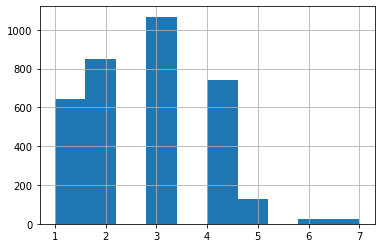

In [18]:
movies_with_tags_ratings.film_variety.hist()

В основном фильмы не разнообразные, ограничиваются 2-4 жанрами

<AxesSubplot:>

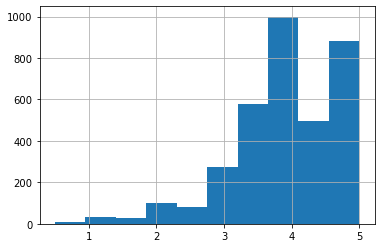

In [19]:
movies_with_tags_ratings.rating.hist()

В основном оценки фильмам ставили выше среднего.

<AxesSubplot:>

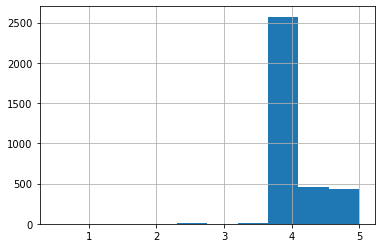

In [20]:
movies_with_tags_ratings.rating_aver_user.hist()

В основном средние оценки пользователей хорошие.

<AxesSubplot:>

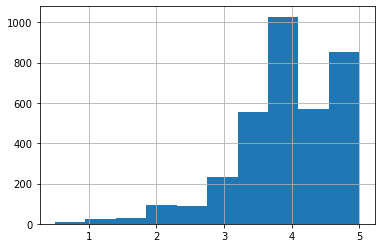

In [21]:
movies_with_tags_ratings.rating_aver_for_film.hist()

В основном средние оценки фильма хорошие 4-5.

<AxesSubplot:>

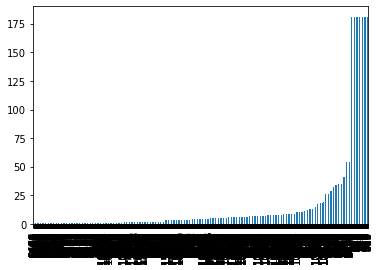

In [22]:
movies_with_tags_ratings.title_film_views.sort_values().plot(kind='bar')

Есть фильмы, которые пересматривают более 50 раз, но в основном меньше 10.

In [23]:
movies_with_tags_ratings.shape

(3476, 10)

In [24]:
movies_with_tags_ratings.head(2)

,movieId,title,genres,userId,tag,rating,rating_aver_user,rating_aver_for_film,film_variety,title_film_views
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,4.0,3.777778,3.833333,5,3
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,4.0,3.701909,3.833333,5,3


In [25]:
y = movies_with_tags_ratings['rating']
X = movies_with_tags_ratings.drop(columns=[ 'movieId', 'userId', 'rating'])

In [26]:
X.head(5)

,title,genres,tag,rating_aver_user,rating_aver_for_film,film_variety,title_film_views
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar,3.777778,3.833333,5,3
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar,3.701909,3.833333,5,3
2,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun,3.917824,3.833333,5,3
3,Jumanji (1995),Adventure|Children|Fantasy,fantasy,3.937838,3.750000,3,4
4,Jumanji (1995),Adventure|Children|Fantasy,magic board game,3.937838,3.750000,3,4


##### TF-IDF на тегах и жанрах


#### Создание колонок возможных тегов

In [27]:
tag_strings = []
for row_num in range(0, len(X)):
    tag_strings.append(X.tag.iloc[row_num].lower().replace('-', ''))

In [28]:
tag_strings[:5]

['pixar', 'pixar', 'fun', 'fantasy', 'magic board game']

In [29]:
len(tag_strings)

3476

#### Создание колонок возможных жанров

In [30]:
def change_string(s):
    return ' '.join(s.lower().replace(' ', '').replace('-', '').split('|'))

In [31]:
movie_genres = [change_string(g) for g in X.genres.values]
movie_genres[:5]

['adventure animation children comedy fantasy',
 'adventure animation children comedy fantasy',
 'adventure animation children comedy fantasy',
 'adventure children fantasy',
 'adventure children fantasy']

In [32]:
len(movie_genres)

3476

#### CountVec  + TfidfVect

In [33]:
count_vect = CountVectorizer()
X_train_counts_tags = count_vect.fit_transform(tag_strings)

In [34]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf_tags = tfidf_transformer.fit_transform(X_train_counts_tags)

In [35]:
X_train_tfidf_tags.shape

(3476, 1712)

In [36]:
X_train_tfidf_tags.toarray()[3475][1711]

0.0

In [37]:
count_vect_2 = CountVectorizer()
X_train_counts_genres = count_vect_2.fit_transform(movie_genres)

In [38]:
tfidf_transformer_2 = TfidfTransformer()
X_train_tfidf_genres = tfidf_transformer_2.fit_transform(X_train_counts_genres)

In [39]:
X_train_tfidf_genres.shape

(3476, 20)

In [40]:
X_train_tfidf_genres.toarray()[3475][19]

0.0

#### Распределение данных по X

In [41]:
X.shape

(3476, 7)

In [42]:
X.iloc[3472:3475, :]

,title,genres,tag,rating_aver_user,rating_aver_for_film,film_variety,title_film_views
11840,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime,3.985714,3.5,4,4
11841,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy,3.985714,3.5,4,4
11842,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,gintama,3.985714,3.5,4,4


In [43]:
for i in range(1, 1713):
    X[f'tag {i}'] = 0
for j in range(1, 21):
    X[f'genre {j}'] = 0

C:\Users\D683~1\AppData\Local\Temp/ipykernel_17064/3608596756.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'tag {i}'] = 0
C:\Users\D683~1\AppData\Local\Temp/ipykernel_17064/3608596756.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'genre {j}'] = 0


In [44]:
X.iloc[:, 7 : 1719].head(2)

,tag 1,tag 2,tag 3,tag 4,tag 5,tag 6,tag 7,tag 8,tag 9,tag 10,...,tag 1703,tag 1704,tag 1705,tag 1706,tag 1707,tag 1708,tag 1709,tag 1710,tag 1711,tag 1712
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
X.iloc[:, 7 : 1719] = X_train_tfidf_tags.toarray()

In [45]:
# for i, column in enumerate(X.iloc[:, 7 : 1719].columns):
#     for row in range(len(X)):
#         X[f'{column}'].iloc[row] = X_train_tfidf_tags.toarray()[row][i]

In [49]:
X.iloc[:, 1719:].head()

,genre 1,genre 2,genre 3,genre 4,genre 5,genre 6,genre 7,genre 8,genre 9,genre 10,genre 11,genre 12,genre 13,genre 14,genre 15,genre 16,genre 17,genre 18,genre 19,genre 20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# for i, column in enumerate(X.iloc[:, 1719:].columns):
#     for row in range(len(X)):
#         X[f'{column}'].iloc[row] = X_train_tfidf_genres.toarray()[row][i]

In [50]:
X.iloc[:, 1719:] = X_train_tfidf_genres.toarray()

In [51]:
X.tail()

,title,genres,tag,rating_aver_user,rating_aver_for_film,film_variety,title_film_views,tag 1,tag 2,tag 3,...,genre 11,genre 12,genre 13,genre 14,genre 15,genre 16,genre 17,genre 18,genre 19,genre 20
11818,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars,3.937838,4.0,4,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.444081,0.0,0.0,0.0
11840,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime,3.985714,3.5,4,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.477320,0.0,0.0,0.0
11841,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy,3.985714,3.5,4,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.477320,0.0,0.0,0.0
11842,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,gintama,3.985714,3.5,4,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.477320,0.0,0.0,0.0
11843,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster,3.985714,3.5,4,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.477320,0.0,0.0,0.0


In [53]:
X = X.drop(columns=['title', 'genres','tag'])

##### Моделирование

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [55]:
X.head(2)

,rating_aver_user,rating_aver_for_film,film_variety,title_film_views,tag 1,tag 2,tag 3,tag 4,tag 5,tag 6,...,genre 11,genre 12,genre 13,genre 14,genre 15,genre 16,genre 17,genre 18,genre 19,genre 20
0,3.777778,3.833333,5,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.701909,3.833333,5,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 42)

## 1. GradientBoostingRegressor

In [57]:
model_1 = GradientBoostingRegressor(random_state=42)
model_1.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

### RMSE - GradientBoostingRegressor

In [58]:
y_predict_1 = model_1.predict(X_test)
mean_squared_error(y_test, y_predict_1)

0.08383953916656181

In [59]:
cross_validate(model_1, X, y, scoring='neg_mean_squared_error', cv=5)

{'fit_time': array([5.80596542, 5.50213838, 5.58458924, 5.80197215, 5.84470844]),
 'score_time': array([0.02100086, 0.02190924, 0.02639079, 0.02015877, 0.02200174]),
 'test_score': array([-0.10175886, -0.032761  , -0.04651901, -0.0549835 , -0.1031351 ])}

## 2. RandomForestRegressor

In [60]:
model_2 = RandomForestRegressor(max_depth=2, random_state=42)
model_2.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=42)

### RMSE - RandomForestRegressor

In [61]:
y_predict_2 = model_2.predict(X_test)
mean_squared_error(y_test, y_predict_2)

0.10848580764397799

In [62]:
cross_validate(model_2, X, y, scoring='neg_mean_squared_error', cv=5)

{'fit_time': array([2.61647415, 2.73436666, 2.71688175, 2.7201786 , 2.67285657]),
 'score_time': array([0.027004  , 0.02599931, 0.02748585, 0.02976131, 0.02014351]),
 'test_score': array([-0.16177773, -0.07202295, -0.07623876, -0.08401031, -0.14406557])}

## Итог

RMSE = 0.083 - лучше всего себя показала модель GradientBoostingRegressor